# Boosting

### Задание 1.

Мы упоминали о том, что у функция потерь AdaBoost имеет более жесткий штраф по отношению к ошибкам классификации, чем другие часто используемые функции. Реализуйте функции logloss и AdaBoost loss, которые возвращают значения штрафов, и посмотрите по графику, насколько сильно они отличаются (примем x = y * y^).

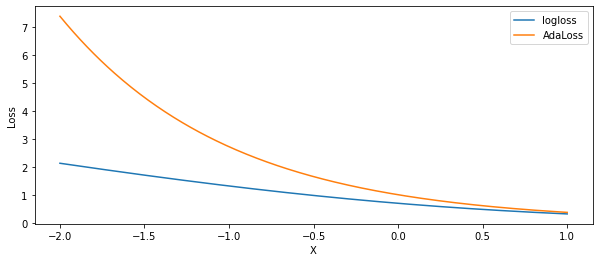

In [4]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(-2, 1, 300)

def logloss(x):
    return np.log(1 + np.exp(-x))

def AdaLoss(x):
    return np.exp(-x)

plt.figure(figsize=(10, 4))
plt.plot(x, logloss(x), label='logloss')
plt.plot(x, AdaLoss(x), label='AdaLoss')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Loss')

x_check = np.array([-2, 0, 2])
y_log = np.array([2.127, 0.693, 0.127])
y_ada = np.array([7.389, 1., 0.135])

assert np.allclose(logloss(x_check), y_log, atol=1e-3), f'Function logloss is not verified'
assert np.allclose(AdaLoss(x_check), y_ada, atol=1e-3), f'Function AdaLoss is not verified'

### Задание 2.

Когда дело доходит до оптимизации алгоритма, зачастую достаточно сложно подобрать сразу такие параметры, при которых качество классификатора было бы максимальным. В этом помогает либо опыт работы с различными методами, либо уже отмеченные другими специалистами взаимосвязи между количеством данных, самим алгоритмом, различными гиперпараметрами и т.п.

В случае с бустингом было отмечено, что количество деревьев, при котором качество алгоритма максимально, зависит от темпа обучения: чем меньше темп, тем больше деревьев обычно требуется. 

В этом задании попробуйте последовательно подобрать такие гиперпараметры n_estimators и learning_rate в алгоритме GBC, чтобы accuracy была равна 1: сначала последовательно увеличивайте количество базовых деревьев, не меняя при этом learning_rate, а затем поменяйте количество деревьев снова на 1 и уже меняйте гиперпараметр learning_rate в пределах (0, 1), не включая границы. Если  accuracy не будет равна 1 при граничном значении learning_rate, добавляйте по одному базовому алгоритму и смотрите, что получится (напомним, что зависимость нелинейная - при значительном увеличении learning_rate количество деревьев может увеличиться всего на одну-две позиции.

Сначала запустите следующий код со сгенерированными данными.

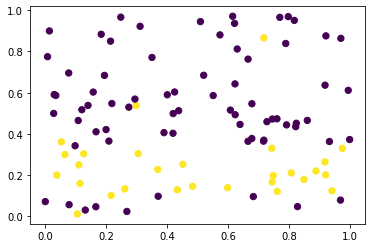

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def plot(alg, data, target):
    xx, yy = np.meshgrid(np.linspace(0., 1., 100), np.linspace(0., 1., 100))
    Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.bwr, alpha=0.3)
    
    plt.scatter(data[:, 0], data[:, 1], s=20, c=targets)
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    

np.random.seed(15)
data = np.random.rand(100, 2)
targets = np.empty(100)
targets[1 / data[:, 1] > 2] = 1
targets[1 / data[:, 1] < 3] = 0
targets[1 / data[:, 1] > 10] = 0
targets[[1, 3, 6, 15, 36]] = 1

plt.scatter(data[:, 0], data[:, 1], s=40, c=targets)

В следующей ячейке можете подбирать параметры алгоритма.

best n_estimators = 33
Accuracy: 1.0


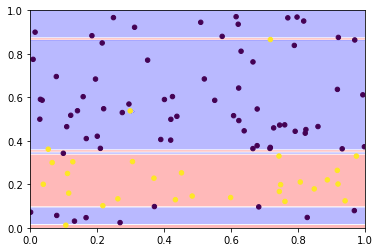

In [13]:
# В этом задании попробуйте последовательно подобрать такие гиперпараметры n_estimators и learning_rate в
# алгоритме GBC, чтобы accuracy была равна 1: сначала последовательно увеличивайте количество базовых
# деревьев, не меняя при этом learning_rate

gbc = GradientBoostingClassifier(n_estimators=1, learning_rate=0.1) # подгонка гиперпараметров
model = gbc.fit(data, targets)
pred = gbc.predict(data)

accuracy = accuracy_score(targets, pred)
max_n_estimators = 50
n_estimators = 1
while accuracy != 1 and n_estimators < max_n_estimators:
    n_estimators += 1
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1) # подгонка гиперпараметров
    model = gbc.fit(data, targets)
    pred = gbc.predict(data)
    accuracy = accuracy_score(targets, pred)

max_n_estimators = n_estimators
print(f'best {n_estimators = }')
print(f'Accuracy: {accuracy_score(targets, pred)}')
plot(gbc, data, targets)

best n_estimators = 2, best_learning_rate = 0.9
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x295CA821440)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x295CA821440)]]


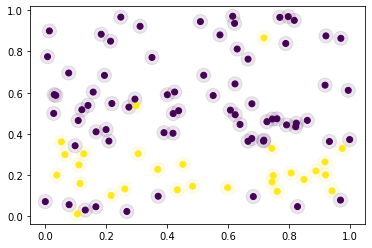

In [46]:
# затем поменяйте количество деревьев снова на 1 и уже меняйте гиперпараметр learning_rate в пределах (0, 1)
# не включая границы. Если accuracy не будет равна 1 при граничном значении learning_rate, добавляйте по
# одному базовому алгоритму и смотрите, что получится (напомним, что зависимость нелинейная - при значительном
# увеличении learning_rate количество деревьев может увеличиться всего на одну-две позиции.

accuracy = 0
n_estimators = 0
best_learning_rate = 0
while accuracy != 1 and n_estimators < max_n_estimators:
    n_estimators += 1
    for lr in np.linspace(0.1, 0.9, 9):
        gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr)
        model = gbc.fit(data, targets)
        pred = gbc.predict(data)
        accuracy = accuracy_score(targets, pred)
        #print(f'{n_estimators = }, {lr = }, {accuracy = }')
        if accuracy == 1:
            best_learning_rate = lr
            break

print(f'best {n_estimators = }, {best_learning_rate = }')
print(gbc.estimators_)

plt.scatter(data[:, 0], data[:, 1], c=gbc.predict(data), alpha=0.1, s=200)
plt.scatter(data[:, 0], data[:, 1], c=targets)